In [90]:
import sys  
sys.path.insert(0, '..')

from datetime import date, timedelta

from config import Config

import pandas as pd
from sqlalchemy import create_engine

import numpy as np

import matplotlib

db = create_engine(Config.SQLALCHEMY_DATABASE_URI)

In [91]:
ockovani = pd.read_sql_query(
    """
    select datum, vekova_skupina, sum(pocet) pocet_ockovani
    from ockovani_lide o
    join vakciny v on (o.vakcina = v.vakcina)
    where poradi_davky = v.davky
    group by datum, vekova_skupina
    order by datum
    """,
    db
)
ockovani['pocet_ockovani'] = ockovani.groupby('vekova_skupina')['pocet_ockovani'].transform(pd.Series.cumsum)
# ockovani

In [92]:
populace = pd.read_sql_query(
    """
    select vekova_skupina, sum(pocet) pocet_populace from populace_kategorie k 
    join populace p on (p.vek >= k.min_vek AND p.vek <= k.max_vek)
    where orp_kod='CZ0'
    group by vekova_skupina
    order by vekova_skupina
    """,
    db
)
# populace

In [93]:
nakazeni = pd.read_sql_query(
    """
    select datum, vekova_skupina, sum(pocet) pocet_nakazeni from nakazeni
    where vekova_skupina != '-'
    group by datum, vekova_skupina
    order by datum
    """,
    db
)
nakazeni = nakazeni.groupby(['vekova_skupina', 'datum']).sum().rolling(7).sum().divide(7)
# nakazeni

In [94]:
df = pd.merge(nakazeni, ockovani, how='outer', on=['datum', 'vekova_skupina'])
df = pd.merge(df, populace, how='outer', on='vekova_skupina')
df = df.fillna(0)
df['nakazeni_100k'] = df['pocet_nakazeni'] * 100000 / df['pocet_populace']
df['ockovani_100k'] = df['pocet_ockovani'] * 100000 / df['pocet_populace']
df['nakazeni_100k_neockovani'] = df['pocet_nakazeni'] * 100000 / (df['pocet_populace'] - df['pocet_ockovani'])
df = df.fillna(0)
df = df.reset_index()
# df

In [95]:
grp1 = '80+'
grp2 = '70-74'

<AxesSubplot:>

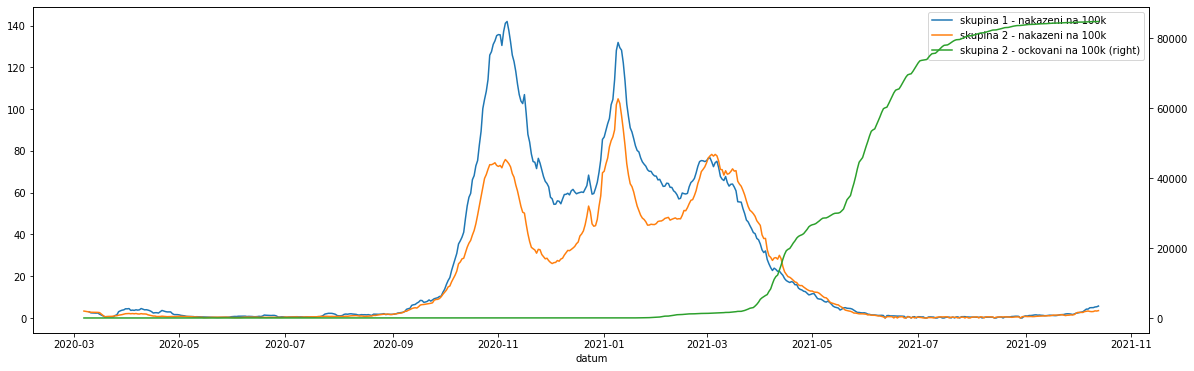

In [96]:
df_grp_1 = df[df['vekova_skupina'] == grp1]
df_grp_2 = df[df['vekova_skupina'] == grp2]

ax = df_grp_1.plot(x='datum', y='nakazeni_100k', label='skupina 1 - nakazeni na 100k', figsize=(20, 6))
# df_grp_1.plot(x='datum', y='ockovani_100k', label='skupina 1 - ockovani na 100k', secondary_y=True, ax=ax)

df_grp_2.plot(x='datum', y='nakazeni_100k', label='skupina 2 - nakazeni na 100k', ax=ax)
df_grp_2.plot(x='datum', y='ockovani_100k', label='skupina 2 - ockovani na 100k', secondary_y=True, ax=ax)

<AxesSubplot:xlabel='datum'>

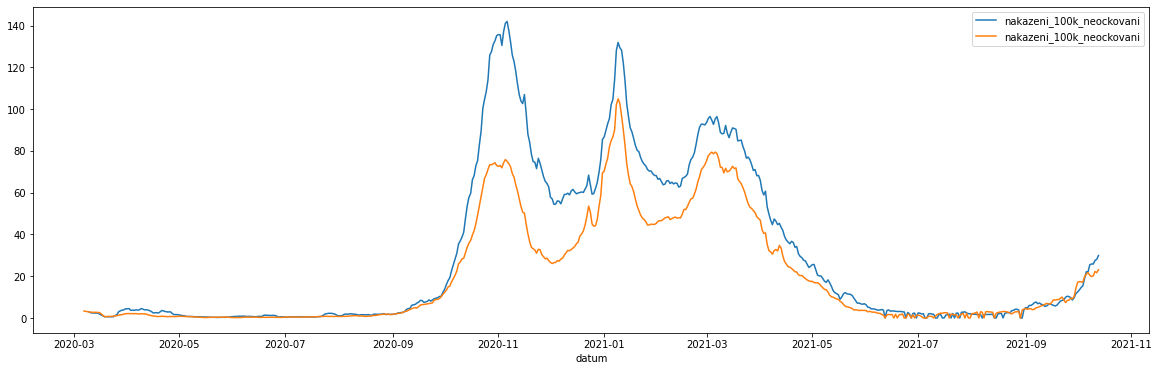

In [97]:
ax1 = df[df['vekova_skupina'] == grp1].plot(x='datum', y='nakazeni_100k_neockovani', figsize=(20, 6))
df[df['vekova_skupina'] == grp2].plot(x='datum', y='nakazeni_100k_neockovani', figsize=(20, 6), ax=ax1)

In [147]:
nakazeni_v = pd.read_sql_query(
    """
    select datum, bez_ockovani nakazeni_bez, dokoncene_ockovani nakazeni_plne, 
        bez_ockovani_vek_prumer nakazeni_bez_vek, dokoncene_ockovani_vek_prumer nakazeni_plne_vek
    from nakazeni_ockovani n 
    where datum <= '2021-10-15'
    """,
    db
)
# nakazeni_v

In [148]:
nakazeni_65_v = pd.read_sql_query(
    """
    select datum, bez_ockovani nakazeni_65_bez, dokoncene_ockovani nakazeni_65_plne 
    from nakazeni_65_ockovani n 
    where datum <= '2021-10-15'
    """,
    db
)
# nakazeni_65_v

In [151]:
hospitalizace_v = pd.read_sql_query(
    """
    select datum, bez_ockovani hospitalizace_bez, dokoncene_ockovani hospitalizace_plne,
        bez_ockovani_vek_prumer hospitalizace_bez_vek, dokoncene_ockovani_vek_prumer hospitalizace_plne_vek
    from hospitalizace_ockovani n 
    where datum <= '2021-10-15'
    """,
    db
)
# hospitalizace_v

In [152]:
hospitalizace_jip_v = pd.read_sql_query(
    """
    select datum, bez_ockovani hospitalizace_jip_bez, dokoncene_ockovani hospitalizace_jip_plne,
        bez_ockovani_vek_prumer hospitalizace_jip_bez_vek, dokoncene_ockovani_vek_prumer hospitalizace_jip_plne_vek
    from hospitalizace_jip_ockovani n 
    where datum <= '2021-10-15'
    """,
    db
)
# hospitalizace_jip_v

In [153]:
umrti_v = pd.read_sql_query(
    """
    select datum, bez_ockovani umrti_bez, dokoncene_ockovani umrti_plne,
        bez_ockovani_vek_prumer umrti_bez_vek, dokoncene_ockovani_vek_prumer umrti_plne_vek
    from umrti_ockovani n 
    where datum <= '2021-10-15'
    """,
    db
)
# umrti_v

In [166]:
populace_v = pd.read_sql_query("select sum(pocet) populace from populace where orp_kod = 'CZ0'", db)
# populace_v

In [167]:
ockovani_v = pd.read_sql_query(
    """
    select datum, 
        sum(case when poradi_davky = 1 then pocet else 0 end) populace_castecne, 
        sum(case when poradi_davky = v.davky then pocet else 0 end) populace_plne, 
        sum(case when poradi_davky = 3 then pocet else 0 end) populace_posilujici
    from ockovani_lide o
    join vakciny v on (o.vakcina = v.vakcina)
    where datum <= '2021-10-14'
    group by datum
    order by datum
    """,
    db
)
ockovani_v[['populace_castecne', 'populace_plne', 'populace_posilujici']] = ockovani_v[['populace_castecne', 'populace_plne', 'populace_posilujici']].transform(pd.Series.cumsum)
# ockovani_v

In [168]:
ockovani_v['key'] = 0
populace_v['key'] = 0
df = pd.merge(ockovani_v, populace_v)
df = df.drop(columns=['key'])
df['populace_bez'] = df['populace'] - df['populace_castecne']

df = pd.merge(df, nakazeni_v)
df = pd.merge(df, nakazeni_65_v)
df = pd.merge(df, hospitalizace_v)
df = pd.merge(df, hospitalizace_jip_v)
df = pd.merge(df, umrti_v)

# df

In [169]:
df['nakazeni_bez_100k'] = (100000 * df['nakazeni_bez']) / df['populace_bez']
df['nakazeni_plne_100k'] = (100000 * df['nakazeni_plne']) / df['populace_plne']
df['nakazeni_ratio'] = (df['nakazeni_bez_100k'] / df['nakazeni_plne_100k']).replace(np.inf, np.nan)

# df['nakazeni_65_bez_100k'] = (100000 * df['nakazeni_65_bez']) / df['populace_bez']
# df['nakazeni_65_plne_100k'] = (100000 * df['nakazeni_65_plne']) / df['populace_plne']
# df['nakazeni_65_ratio'] = (df['nakazeni_65_bez_100k'] / df['nakazeni_65_plne_100k']).replace(np.inf, np.nan)

df['hospitalizace_bez_100k'] = (100000 * df['hospitalizace_bez']) / df['populace_bez']
df['hospitalizace_plne_100k'] = (100000 * df['hospitalizace_plne']) / df['populace_plne']
df['hospitalizace_ratio'] = (df['hospitalizace_bez_100k'] / df['hospitalizace_plne_100k']).replace(np.inf, np.nan)

df['hospitalizace_jip_bez_100k'] = (100000 * df['hospitalizace_jip_bez']) / df['populace_bez']
df['hospitalizace_jip_plne_100k'] = (100000 * df['hospitalizace_jip_plne']) / df['populace_plne']
df['hospitalizace_jip_ratio'] = (df['hospitalizace_jip_bez_100k'] / df['hospitalizace_jip_plne_100k']).replace(np.inf, np.nan)

df['umrti_bez_100k'] = (100000 * df['umrti_bez']) / df['populace_bez']
df['umrti_plne_100k'] = (100000 * df['umrti_plne']) / df['populace_plne']
df['umrti_ratio'] = (df['umrti_bez_100k'] / df['umrti_plne_100k']).replace(np.inf, np.nan)

# df

In [161]:
df_ratio = df[['datum', 'nakazeni_ratio', 'hospitalizace_ratio', 'hospitalizace_jip_ratio', 'umrti_ratio']].copy()
df_ratio = df_ratio.rolling(30, on='datum').mean(skipna=True)
df_ratio

,datum,hospitalizace_jip_ratio,hospitalizace_ratio,nakazeni_ratio,umrti_ratio
0,2021-01-01,NaN,NaN,NaN,NaN
1,2021-01-02,NaN,NaN,NaN,NaN
2,2021-01-03,NaN,NaN,NaN,NaN
3,2021-01-04,NaN,NaN,NaN,NaN
4,2021-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...
281,2021-10-09,NaN,4.243777,5.086131,NaN
282,2021-10-10,NaN,4.126405,5.009722,NaN
283,2021-10-11,NaN,4.158081,4.947016,NaN
284,2021-10-12,NaN,4.048934,4.934586,NaN


In [165]:
df_vek = df[['datum', 
             'nakazeni_bez', 'nakazeni_bez_vek', 'nakazeni_plne', 'nakazeni_plne_vek',
             'hospitalizace_bez', 'hospitalizace_bez_vek', 'hospitalizace_plne', 'hospitalizace_plne_vek',
             'hospitalizace_jip_bez', 'hospitalizace_jip_bez_vek', 'hospitalizace_jip_plne', 'hospitalizace_jip_plne_vek',
             'umrti_bez', 'umrti_bez_vek', 'umrti_plne', 'umrti_plne_vek']].copy()

df_vek['nakazeni_bez_mult'] = df_vek['nakazeni_bez'] * df_vek['nakazeni_bez_vek']
df_vek['nakazeni_plne_mult'] = df_vek['nakazeni_plne'] * df_vek['nakazeni_plne_vek']

df_vek['hospitalizace_bez_mult'] = df_vek['hospitalizace_bez'] * df_vek['hospitalizace_bez_vek']
df_vek['hospitalizace_plne_mult'] = df_vek['hospitalizace_plne'] * df_vek['hospitalizace_plne_vek']

df_vek['hospitalizace_jip_bez_mult'] = df_vek['hospitalizace_jip_bez'] * df_vek['hospitalizace_jip_bez_vek']
df_vek['hospitalizace_jip_plne_mult'] = df_vek['hospitalizace_jip_plne'] * df_vek['hospitalizace_jip_plne_vek']

df_vek['umrti_bez_mult'] = df_vek['umrti_bez'] * df_vek['umrti_bez_vek']
df_vek['umrti_plne_mult'] = df_vek['umrti_plne'] * df_vek['umrti_plne_vek']

df_vek = df_vek.rolling(30, on='datum').sum()

df_vek['nakazeni_bez_vek'] = df_vek['nakazeni_bez_mult'] / df_vek['nakazeni_bez']
df_vek['nakazeni_plne_vek'] = df_vek['nakazeni_plne_mult'] / df_vek['nakazeni_plne']

df_vek['hospitalizace_bez_vek'] = df_vek['hospitalizace_bez_mult'] / df_vek['hospitalizace_bez']
df_vek['hospitalizace_plne_vek'] = df_vek['hospitalizace_plne_mult'] / df_vek['hospitalizace_plne']

df_vek['hospitalizace_jip_bez_vek'] = df_vek['hospitalizace_jip_bez_mult'] / df_vek['hospitalizace_jip_bez']
df_vek['hospitalizace_jip_plne_vek'] = df_vek['hospitalizace_jip_plne_mult'] / df_vek['hospitalizace_jip_plne']

df_vek['umrti_bez_vek'] = df_vek['umrti_bez_mult'] / df_vek['umrti_bez']
df_vek['umrti_plne_vek'] = df_vek['umrti_plne_mult'] / df_vek['umrti_plne']

df_vek[['datum', 'nakazeni_bez_vek', 'nakazeni_plne_vek', 'hospitalizace_bez_vek', 'hospitalizace_plne_vek', 'hospitalizace_jip_bez_vek', 'hospitalizace_jip_plne_vek', 'umrti_bez_vek', 'umrti_plne_vek']]

,datum,nakazeni_bez_vek,nakazeni_plne_vek,hospitalizace_bez_vek,hospitalizace_plne_vek,hospitalizace_jip_bez_vek,hospitalizace_jip_plne_vek,umrti_bez_vek,umrti_plne_vek
0,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
281,2021-10-09,27.643103,50.609556,55.439856,74.493151,59.793651,75.224490,74.463415,79.083333
282,2021-10-10,27.684353,50.512821,55.434095,74.823009,59.578125,75.784314,74.227273,78.720000
283,2021-10-11,27.659656,50.509024,55.646281,74.804082,59.929078,75.771930,74.177778,79.100000
284,2021-10-12,27.689858,50.302673,55.895238,74.740458,59.453947,75.696429,73.500000,78.228571
